This notebook provides a demo of the basic capabilities and use of the MAF python interface, using MetricBundle and MetricBundleGroup. To use this notebook, you need a version of MAF >= 1.0, available via eups installation (eups distrib [install](https://confluence.lsstcorp.org/display/SIM/Catalogs+and+MAF) sims_maf -t sims_maf, after installing the base LSST software stack requirements). 

In [1]:
# import matplotlib to show plots here
import matplotlib.pyplot as plt
%matplotlib inline

Import the sims_maf modules needed.

In [2]:
# import our python modules
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.metricBundles as metricBundles

'MetricBundles' combine a particular metric, a slicer, and a sqlconstraint. You can also add additional provenance/metadata information to a given benchmark, in the form of the (opsim) runName and a metadata comment. This information will be used to generate outfile filenames and plot labels. A given metricbundle will also store the metric values calculated at each point of the slicer (after this is generated via the 'MetricBundleGroup' methods). 

To instantiate a MetricBundle, first instantiate a [`Metric`](https://confluence.lsstcorp.org/display/SIM/MAF+Metrics) and [`Slicer`](https://confluence.lsstcorp.org/display/SIM/MAF+Slicers), then the `MetricBundle` to store the combination of the two. Here we'll calculate the minimum airmass value, at each point in a healpix grid.

In [3]:
metric1 = metrics.MinMetric('airmass')
slicer1 = slicers.HealpixSlicer(nside=64)
sqlconstraint= 'filter = "r"'
minairmassSky = metricBundles.MetricBundle(metric1, slicer1, sqlconstraint)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


Here is another example of a `MetricBundle`, this time reusing the same slicer, but changing the metric - this time we'll count the number of visits at each point in the healpix grid.

In [4]:
metric2 = metrics.CountMetric('expMJD')
nvisitsSky = metricBundles.MetricBundle(metric2, slicer1, sqlconstraint)

We can also add ["summary metrics"](https://confluence.lsstcorp.org/display/SIM/MAF+Summary+Statistics) - metrics that will generate statistical summaries of the metric data values -- and add these to the MetricBundle to run later.

In [5]:
summaryMetrics = [metrics.MinMetric(), metrics.MedianMetric(), metrics.MaxMetric(), metrics.RmsMetric()]
minairmassSky.setSummaryMetrics(summaryMetrics)
nvisitsSky.setSummaryMetrics(summaryMetrics)

And here is yet another example, where we'll use a different slicer, but the same metrics as above, and add the summaryMetrics directly into the construction of the MetricBundle.

In [6]:
slicer2 = slicers.OneDSlicer(sliceColName='night', binsize=1, binMin=0, binMax=365*10)
nvisitsPerNight = metricBundles.MetricBundle(metric1, slicer2, sqlconstraint, summaryMetrics=summaryMetrics)
minairmassPerNight = metricBundles.MetricBundle(metric2, slicer2, sqlconstraint, summaryMetrics=summaryMetrics)

---
We group MetricBundles with the same sql constraint together into a dictionary, which will be passed to the MetricBundleGroup to run the MetricBundles, calculating the metric values.

In [7]:
bDict = {'minairmassSky':minairmassSky, 'minairmassPerNight':minairmassPerNight, 
        'nvisitsSky':nvisitsSky, 'nvisitsPerNight':nvisitsPerNight}

Now we set up our connections to the opsim database, and a 'results database' where we will store information about the metricbundles which were run.

In [20]:
opsdb = db.OpsimDatabase('sqlite:///enigma_1189_sqlite.db')
outDir = 'bundle_test'
resultsDb = db.ResultsDb(outDir=outDir)

Ready to do some calculating! Instantiate the MetricBundleGroup by passing it the dictionary of MetricBundles to run (they must have the same sql constraint), the opsim database object, and optionally, the output directory and the results database object.

In [9]:
bgroup = metricBundles.MetricBundleGroup(bDict, opsdb, outDir=outDir, resultsDb=resultsDb)

The MetricBundleGroup will now query the data from the opsim database and calculate the metric values, using the 'runAll' method. Note that MAF determines what columns you need from the database for your metrics and slicers, and only queries for those. MAF calculates the metrics in an efficient manner, caching results where possible and iterating through each slicer only once for all related metrics. This step also generates the summary statistics set by each bundle's summaryMetrics (these can also be generated or re-generated independently using 'summaryAll on MetricBundleGroup or directly for a single MetricBundle using 'computeSummaryStats').

In [10]:
bgroup.runAll()

Querying database with constraint filter = "r"
Found 544710 visits
Running:  ['minairmassSky', 'nvisitsSky']
Completed metric generation.
Running:  ['nvisitsPerNight', 'minairmassPerNight']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


/Users/lynnej/anaconda/lib/python2.7/site-packages/sqlalchemy/sql/elements.py:3738: SAWarning: Textual SQL expression 'filter = "r"' should be explicitly declared as text('filter = "r"') (this warning may be suppressed after 10 occurrences)
  {"expr": util.ellipses_string(element)})


---
The results of the metric calculation are stored as an attribute in each metricbundle, as 'metricValues' - a numpy masked array. The results of the summary statistics are also stored in each metricbundle, in a list called 'summaryValues', which contains lists of the summarymetric name + value. 

In [11]:
nvisitsSky.metricValues

masked_array(data = [-- -- -- ..., 30.0 30.0 60.0],
             mask = [ True  True  True ..., False False False],
       fill_value = -1.6375e+30)

In [12]:
for k, b in bDict.iteritems():
    print '--', k, '--'
    for summaryName, summaryVal in b.summaryValues:
        print '\t', summaryName, summaryVal

-- minairmassSky --
	Min 1.001869
	Median 1.072127
	Max 2.423889
	Rms 0.202164512234
-- nvisitsSky --
	Min 30.0
	Median 200.0
	Max 4739.0
	Rms 192.031895572
-- nvisitsPerNight --
	Min 1.001869
	Median 1.005705
	Max 2.27117
	Rms 0.120768452148
-- minairmassPerNight --
	Min 1.0
	Median 299.5
	Max 988.0
	Rms 293.025638578


We can save the MetricBundle results to disk. Each MetricBundle has a method called 'write' that writes to disk; using 'writeAll' on the MetricBundleGroup just writes all metricBundles to disk at once as a convenience.

In [13]:
bgroup.writeAll()

In [14]:
!ls $outDir

opsim_Count_expMJD_r_HEAL.npz opsim_Count_expMJD_r_ONED.npz opsim_Min_airmass_r_HEAL.npz  opsim_Min_airmass_r_ONED.npz  resultsDb_sqlite.db


And we can generate plots (which are also saved to disk by default). Again, the MetricBundleGroup has a method called 'plotAll' which will generate all plots for all MetricBundles, but we can call 'plot' on the individual MetricBundles to generate plots just for that bundle. 

Optimal bin calculation tried to make 655 bins, returning 200


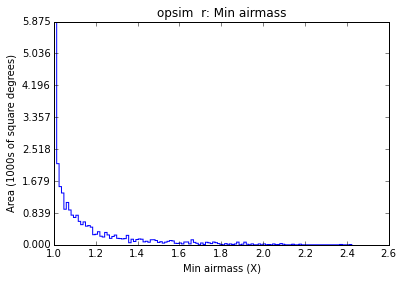

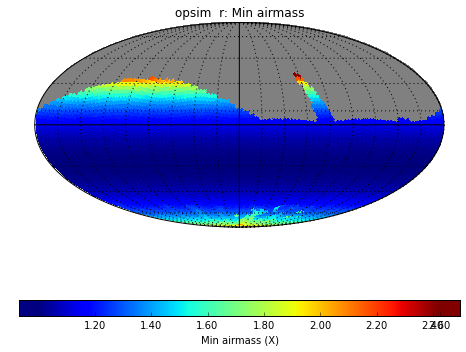

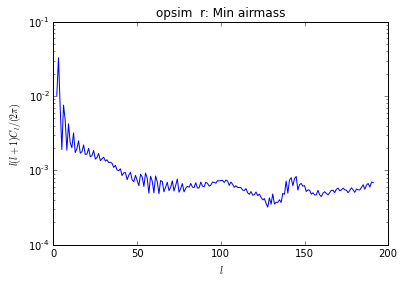

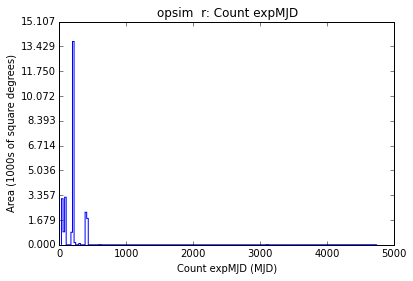

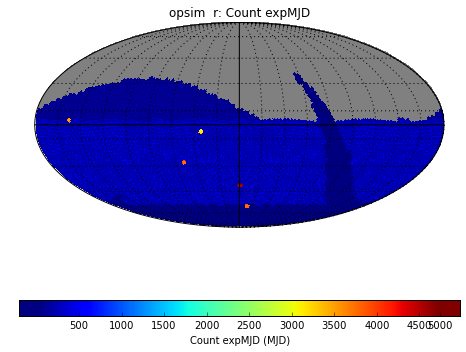

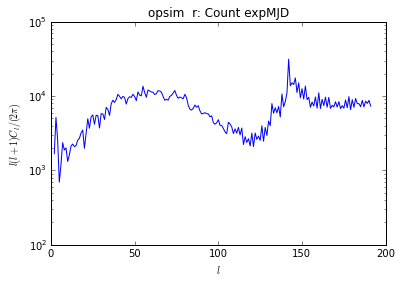

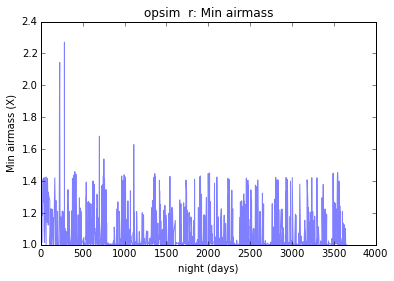

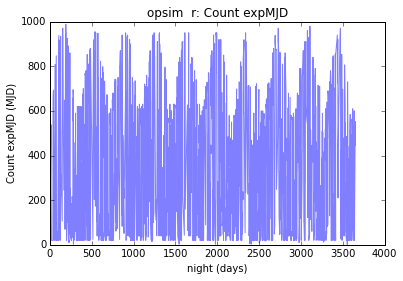

In [15]:
bgroup.plotAll()

We can edit the plotting parameters, by setting values in the plotDict associated with each MetricBundle. 

In [16]:
nvisitsSky.plotDict

{'cbarFormat': '%d',
 'title': 'opsim  r: Count expMJD',
 'units': 'MJD',
 'xlabel': 'Count expMJD (MJD)'}

In [17]:
newPlotParams = {'xMin':0, 'xMax':300, 'colorMin':0, 'colorMax':300, 'xlabel':'Nvisits'}
nvisitsSky.setPlotDict(newPlotParams)

In [18]:
nvisitsSky.plotDict

{'cbarFormat': '%d',
 'colorMax': 300,
 'colorMin': 0,
 'title': 'opsim  r: Count expMJD',
 'units': 'MJD',
 'xMax': 300,
 'xMin': 0,
 'xlabel': 'Nvisits'}

And replot. (here we'll just replot the skymap).

{'SkyMap': 1}

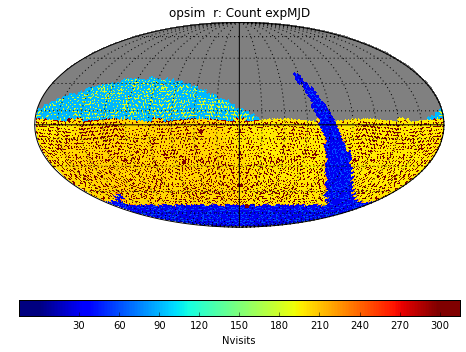

In [19]:
nvisitsSky.plot(plotFunc='plotSkyMap')